#Noise Compensation using Spectrogram Morphological Filtering
In this project we try out image based morphological filtering to audio spectrograms for removing noise from audio signals. Regions of the spectrogram having high energy are estimated to be of more importance and likely to contain the original audio signal. The process of erosion can remove noise while dilation can then restore any erroneously removed signal regions. The combination of the two techniques results
in a non-linear, time-frequency filter. We then recreate the denoised audio from the processed spectrogram.

## Importing all the essential modules:

In [2]:
from scipy.ndimage import binary_erosion
import scipy
from scipy.ndimage import binary_dilation
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import librosa


## Read signals
First off let's create an audio signal with 3 musical tones.
 

In [15]:
sig_noisy_path= "data/train_small/noisy/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"
sig_path= "data/train_small/original/signal/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"

sig_noisy, sr_noisy = librosa.load(sig_noisy_path, sr=None)  
sig, sr = librosa.load(sig_path, sr=None)  

print("noisy singnal:")
display(ipd.Audio(data= sig_noisy, rate= sr_noisy))
print("original signal:")
display(ipd.Audio(data= sig, rate=sr))


noisy singnal:


original signal:


##helper functions for creating plots and displaying them

In [92]:
import matplotlib.pyplot as plt

def draw_spectrogram(sr, magnitude, hop_length_fft, figure_size=(8, 4)):
    """
    Plots the spectrogram from the magnitude of the stft.
    """
    magnitude_db = librosa.amplitude_to_db(np.abs(magnitude), ref=np.max)
    plt.figure(figsize=figure_size)  # Adjust the figure size here
    librosa.display.specshow(magnitude_db, sr=sr, hop_length=hop_length_fft, x_axis='time', y_axis='hz')
    plt.show()  # Display the plot


def draw_timeseries(input_signal,time):
  """
  plots the audio signal
  """
  plt.rcParams['figure.figsize']=[10,5]
  plt.rcParams.update({'font.size':10})
  plt.plot(time,input_signal,color='c',linewidth=1.5,label="input")
  plt.xlim=(time[0],time[-1])
  plt.title('Signal')
  plt.ylabel('Amplitude')
  plt.xlabel('Time[sec]')


## Spectrograms of the song and noisy song we created.
We can create spectrograms of the audio signal by taking the STFT(short time fourier transform) of the signal and plotting just the magnitude of this complex valued function(Zxx).

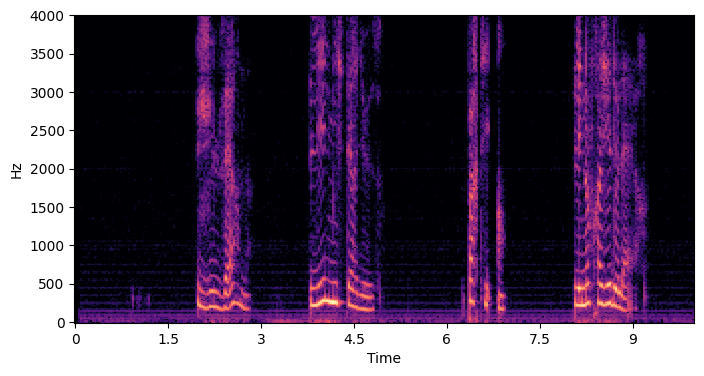

In [93]:
n_fft= 512
hop_length_fft= 256
# Compute the STFT
stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length_fft)
magnitude, phase = librosa.magphase(stft)
draw_spectrogram(sr,magnitude,hop_length_fft)


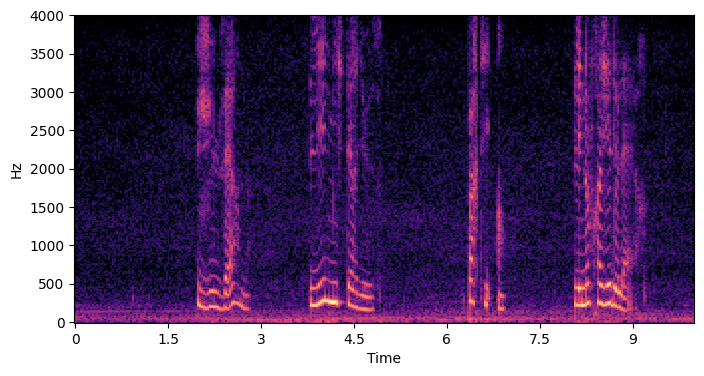

In [94]:
stft = librosa.stft(sig_noisy, n_fft=n_fft, hop_length=hop_length_fft)
magnitude, phase = librosa.magphase(stft)
draw_spectrogram(sr,magnitude,hop_length_fft)


In [25]:
print(magnitude.shape)

(257, 313)


Zxx is a complex valued signal(stft of the audio signal) whose magnitude we plot as the spectrogram.
By comparing the spectrograms of the original and noisy audio signals, we see that if we can filter out just the bright parts, we can reconstruct the original without any of the noise.

## Denoise function
We need to make a function that takes in the complex valued Zxx and gives out the complex valued Rxx as the recovered stft signal, with which we can then do inverse stft to get our final recovered denoised audio signal.

There are 4 steps in the process:
* Create a grayscale image from the magnitude of Zxx.
* Apply binary thresholding.
* Apply morphological processing to get the mask image.
* Using this mask image we create Rxx.

In [88]:
def morph_denoise(Zxx,threshold,amp):
  
  zmax=(np.max(np.abs(Zxx)))
  
  gray_image=20 * np.log10(np.abs(Zxx*(255/zmax)))
  
  thresh_image=np.where(gray_image>=threshold,1,0)# binary thresholding

  mask_image = binary_erosion(thresh_image,iterations=1)
  mask_image = binary_dilation(mask_image,iterations=3)


  figure ,axis_arr = plt.subplots(1,3)
  plt.rcParams['figure.figsize']=[15,10]
  plt.rcParams.update({'font.size':10})
  axis_arr[0].set_title("grayscale spectrogram")
  axis_arr[0].imshow(gray_image)
  axis_arr[1].set_title("After binary thresholding")
  axis_arr[1].imshow(thresh_image)
  axis_arr[2].set_title("After Morphological filtering")
  axis_arr[2].imshow(mask_image)
  Rxx = np.where(mask_image==1,Zxx*amp ,Zxx/amp)
  
  return Rxx


Now let's apply the denoise function on Zxx to get Rxx.

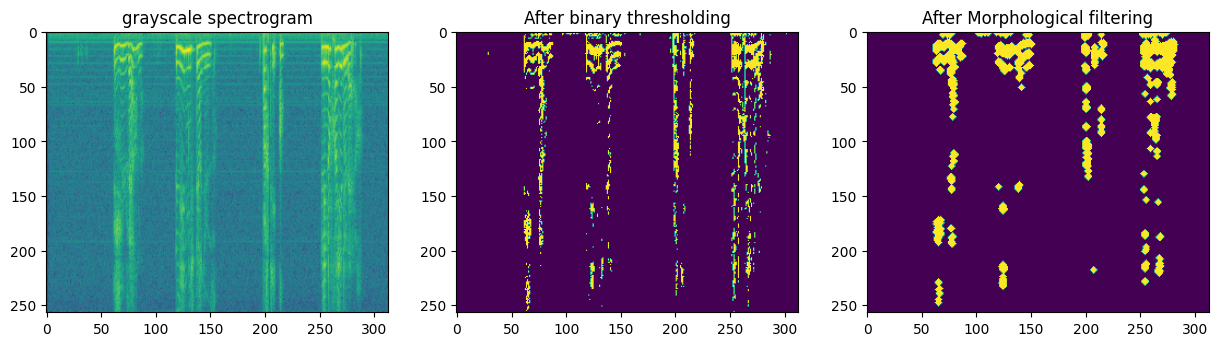

In [89]:
Rxx=morph_denoise(magnitude,threshold=0.01,amp=5)


The image we process looks different from the spectrogram because the axis are flipped(image indices start from 0 from the top). But that doesn't affect the processing.
 
Let's take a look at the spectrogram of the recovered signal.

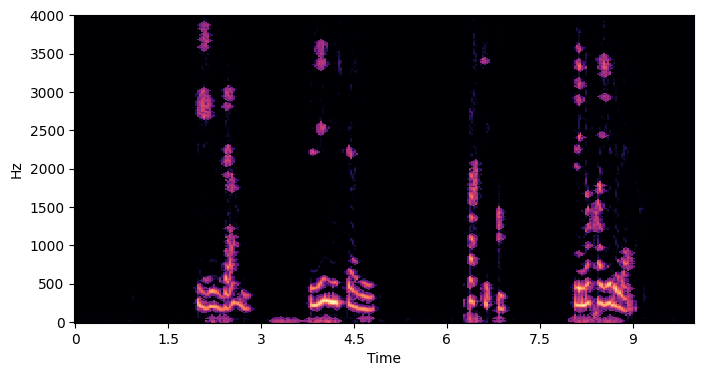

In [95]:
draw_spectrogram(sr,Rxx,hop_length_fft)

Now we reconstruct the audio signal from Rxx by applying inverse short time fourier transform.

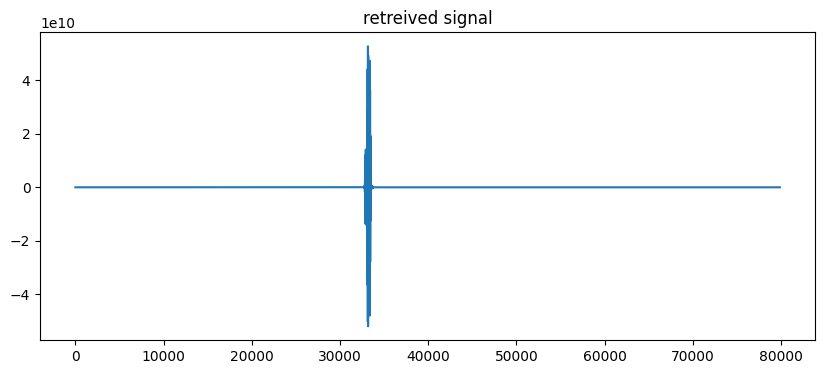

(79872,)


In [91]:
from data import retreive_sig
fs= 8000

def retreive_sig(magnitude_db, phase,n_fft, hop_length_fft ):
    #first go backt othe magnitude scale
    magnitude= librosa.db_to_amplitude(magnitude_db, ref= 1.0)
    #include the phase
    signal_with_phase= magnitude * phase
    #recsntrct
    audio= librosa.core.istft(signal_with_phase, hop_length=hop_length_fft, n_fft=n_fft, center=True)
    if len(audio.shape)==3:
        if audio.shape[2]<80000:
            diff= 80000- audio.shape[2]
            audio =np.pad(audio,((0,0), (0,0),(0, diff)), mode= 'constant')
            audio= audio.reshape(-1, 80000)
    return audio





audio_retrieved= retreive_sig(Rxx, phase, n_fft, hop_length_fft)
plt.figure(figsize=(10,4))
plt.plot(audio_retrieved)
plt.title('retreived signal')
plt.show()


display(ipd.Audio(data= audio_retrieved, rate= fs))
print(audio_retrieved.shape)